## MIMICIII Mechanical Ventilation MAgECs

In [1]:
import numpy as np
import pandas as pd
import psycopg2
import os 
import random
import datetime
from sqlalchemy import create_engine
import matplotlib.pyplot as plt
import magec_utils as mg
from keras.layers import LSTM
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score
from sklearn.metrics import confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.utils import class_weight

%matplotlib inline

random.seed(22891)

Using TensorFlow backend.


In [2]:
pd.set_option('display.max_columns', None)

### Get data

In [3]:
# information used to create a database connection
sqluser = 'postgres'
dbname = 'mimic'
schema_name = 'mimiciii'

engine = create_engine("postgresql+psycopg2://{}:{}@/{}".format(sqluser, sqluser, dbname))

schema_name = 'mimiciii'
conn = engine.connect()
conn.execute('SET search_path to ' + schema_name)

df = pd.read_sql("SELECT * FROM mimic_users_study;", conn)
conn.close()

### Timepoint represents hours prior to event (order in descending order)

In [4]:
df = df.sort_values(['subject_id', 'timepoint'], ascending=(1,0))

In [5]:
df.head(3)

,subject_id,hadm_id,icustay_id,timepoint,event_time,ventilated,mv_start,aniongap,albumin,bicarbonate,bilirubin,creatinine,chloride,glucose,hematocrit,hemoglobin,lactate,magnesium,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,age,first_icu_stay,adult_icu,first_careunit,diagnosis,curr_service,dischtime,admission_type,mort_icu,gender,admittime,los_icu,mv_hours,los_icu_hr,mv_end,los_hospital,first_hosp_stay,outtime,intime,ventnum,prev_service,transfertime,ethnicity,congestive_heart_failure,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,hypertension,paralysis,other_neurological,chronic_pulmonary,diabetes_uncomplicated,diabetes_complicated,hypothyroidism,renal_failure,liver_disease,peptic_ulcer,aids,lymphoma,metastatic_cancer,solid_tumor,rheumatoid_arthritis,coagulopathy,obesity,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression
23,4,185777,294638,26,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,111.0,NaN,NaN,NaN,NaN,37.444445,98.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22,4,185777,294638,25,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,100.0,116.0,63.0,80.666702,NaN,NaN,98.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
21,4,185777,294638,24,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,88.0,NaN,NaN,NaN,NaN,NaN,99.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Featurize

In [6]:
vitals = ['heartrate_mean', 'sysbp_mean', 'diasbp_mean', 'meanbp_mean',
          'resprate_mean', 'tempc_mean', 'spo2_mean', 'glucose_mean']
labs = ['aniongap', 'albumin', 'bicarbonate', 'bilirubin', 'creatinine', 
        'chloride', 'glucose', 'hemoglobin', 'lactate', 
        'magnesium', 'phosphate', 'platelet', 'potassium', 'ptt', 'inr', 
        'pt', 'sodium', 'bun', 'wbc']  # -hematocrit
comobs = ['congestive_heart_failure', 'chronic_pulmonary', 'pulmonary_circulation']
others = ['age', 'gender']

In [7]:
def last_val(x):
    vals = x[~np.isnan(x)]
    if len(vals):
        return vals[-1]
    else:
        return None
    
def featurize_time(df):
    out = dict()
    for i in range(len(df)):
        for lab in labs:
            val = last_val(df[lab].values[:i+1])
            if lab not in out:
                out[lab] = [val]
            else:
                out[lab].append(val)
        for vital in vitals:    
            val = last_val(df[vital].values[:i+1])
            if vital not in out:
                out[vital] = [val]
            else:
                out[vital].append(val)
        for comob in comobs:    
            val = last_val(df[comob].values[:i+1])
            if comob not in out:
                out[comob] = [val]
            else:
                out[comob].append(val)
        for other in others:
            val = last_val(df[other].values[:i+1])
            if other not in out:
                out[other] = [val]
            else:
                out[other].append(val)
        out['timepoint'] = df.timepoint.values
        out['label'] = [int(x) for x in df.ventilated.values]
    return pd.Series(out)

def featurize(df):
    out = dict()
    for lab in labs:
        out[lab] = last_val(df[lab])
    for vital in vitals:
        out[vital] = last_val(df[vital])
    for comob in comobs:
        out[comob] = last_val(df[comob])
    for other in others:
        out[other] = last_val(df[other])
    out['label'] = int(df.ventilated.iloc[-1])
    return pd.Series(out)

### Example from 'original' dataframe

In [8]:
df[df['subject_id']==4].head(3)

,subject_id,hadm_id,icustay_id,timepoint,event_time,ventilated,mv_start,aniongap,albumin,bicarbonate,bilirubin,creatinine,chloride,glucose,hematocrit,hemoglobin,lactate,magnesium,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,age,first_icu_stay,adult_icu,first_careunit,diagnosis,curr_service,dischtime,admission_type,mort_icu,gender,admittime,los_icu,mv_hours,los_icu_hr,mv_end,los_hospital,first_hosp_stay,outtime,intime,ventnum,prev_service,transfertime,ethnicity,congestive_heart_failure,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,hypertension,paralysis,other_neurological,chronic_pulmonary,diabetes_uncomplicated,diabetes_complicated,hypothyroidism,renal_failure,liver_disease,peptic_ulcer,aids,lymphoma,metastatic_cancer,solid_tumor,rheumatoid_arthritis,coagulopathy,obesity,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression
23,4,185777,294638,26,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,111.0,NaN,NaN,NaN,NaN,37.444445,98.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
22,4,185777,294638,25,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,100.0,116.0,63.0,80.666702,NaN,NaN,98.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
21,4,185777,294638,24,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,88.0,NaN,NaN,NaN,NaN,NaN,99.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [9]:
df[df['subject_id']==4].tail(3)

,subject_id,hadm_id,icustay_id,timepoint,event_time,ventilated,mv_start,aniongap,albumin,bicarbonate,bilirubin,creatinine,chloride,glucose,hematocrit,hemoglobin,lactate,magnesium,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,age,first_icu_stay,adult_icu,first_careunit,diagnosis,curr_service,dischtime,admission_type,mort_icu,gender,admittime,los_icu,mv_hours,los_icu_hr,mv_end,los_hospital,first_hosp_stay,outtime,intime,ventnum,prev_service,transfertime,ethnicity,congestive_heart_failure,cardiac_arrhythmias,valvular_disease,pulmonary_circulation,peripheral_vascular,hypertension,paralysis,other_neurological,chronic_pulmonary,diabetes_uncomplicated,diabetes_complicated,hypothyroidism,renal_failure,liver_disease,peptic_ulcer,aids,lymphoma,metastatic_cancer,solid_tumor,rheumatoid_arthritis,coagulopathy,obesity,weight_loss,fluid_electrolyte,blood_loss_anemia,deficiency_anemias,alcohol_abuse,drug_abuse,psychoses,depression
2,4,185777,294638,5,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,99.0,133.0,79.0,97.000000,26.0,NaN,98.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
1,4,185777,294638,4,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,94.0,NaN,NaN,NaN,NaN,NaN,97.0,153.0,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
0,4,185777,294638,3,2191-03-17 03:29:31,0,NaT,17.0,2.8,24.0,2.2,0.5,97.0,140.0,34.2,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,97.0,119.0,69.0,85.666702,28.0,NaN,98.0,NaN,47.0,1,1,MICU,"FEVER,DEHYDRATION,FAILURE TO THRIVE",MED,2191-03-23 18:41:00,EMERGENCY,0,0,2191-03-16 00:28:00,1.0,NaN,40.0,NaT,7.0,1,2191-03-17 16:46:31,2191-03-16 00:29:31,NaN,None,2191-03-16 00:29:31,white,0.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


### Dataframe w/o time (for 'static' models)

In [10]:
df_ml = df.set_index(['subject_id', 'timepoint']).groupby(level=0, group_keys=False).\
                                                  apply(featurize).reset_index()

In [11]:
df_ml[df_ml['subject_id']==4].head(3)

,subject_id,aniongap,albumin,bicarbonate,bilirubin,creatinine,chloride,glucose,hemoglobin,lactate,magnesium,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,congestive_heart_failure,chronic_pulmonary,pulmonary_circulation,age,gender,label
0,4,17.0,2.8,24.0,2.2,0.5,97.0,140.0,11.5,2.1,1.9,3.2,207.0,3.1,31.3,1.0,12.3,135.0,9.0,9.7,97.0,119.0,69.0,85.666702,28.0,36.666667,98.0,153.0,0.0,0.0,0.0,47.0,0.0,0.0


### Dataframe w/ time (for 'timepoint' MAgECs)

In [12]:
df_time = df.set_index(['subject_id']).groupby(level=0, group_keys=False).\
                                       apply(featurize_time).apply(pd.Series.explode).reset_index()

In [13]:
df_time[df_time['subject_id']==4].head(3)

,subject_id,aniongap,albumin,bicarbonate,bilirubin,creatinine,chloride,glucose,hemoglobin,lactate,magnesium,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,congestive_heart_failure,chronic_pulmonary,pulmonary_circulation,age,gender,timepoint,label
0,4,17,2.8,24,2.2,0.5,97,140,11.5,2.1,1.9,3.2,207,3.1,31.3,1,12.3,135,9,9.7,111,None,None,None,None,37.4444,98,None,0,0,0,47,0,26,0
1,4,17,2.8,24,2.2,0.5,97,140,11.5,2.1,1.9,3.2,207,3.1,31.3,1,12.3,135,9,9.7,100,116,63,80.6667,None,37.4444,98,None,0,0,0,47,0,25,0
2,4,17,2.8,24,2.2,0.5,97,140,11.5,2.1,1.9,3.2,207,3.1,31.3,1,12.3,135,9,9.7,88,116,63,80.6667,None,37.4444,99,None,0,0,0,47,0,24,0


In [14]:
df_time[df_time['subject_id']==4].tail(3)

,subject_id,aniongap,albumin,bicarbonate,bilirubin,creatinine,chloride,glucose,hemoglobin,lactate,magnesium,phosphate,platelet,potassium,ptt,inr,pt,sodium,bun,wbc,heartrate_mean,sysbp_mean,diasbp_mean,meanbp_mean,resprate_mean,tempc_mean,spo2_mean,glucose_mean,congestive_heart_failure,chronic_pulmonary,pulmonary_circulation,age,gender,timepoint,label
21,4,17,2.8,24,2.2,0.5,97,140,11.5,2.1,1.9,3.2,207,3.1,31.3,1,12.3,135,9,9.7,99,133,79,97,26,36.6667,98,241,0,0,0,47,0,5,0
22,4,17,2.8,24,2.2,0.5,97,140,11.5,2.1,1.9,3.2,207,3.1,31.3,1,12.3,135,9,9.7,94,133,79,97,26,36.6667,97,153,0,0,0,47,0,4,0
23,4,17,2.8,24,2.2,0.5,97,140,11.5,2.1,1.9,3.2,207,3.1,31.3,1,12.3,135,9,9.7,97,119,69,85.6667,28,36.6667,98,153,0,0,0,47,0,3,0


### Train/Valid Split

In [15]:
seed = 7
np.random.seed(seed)

x = df_ml[list(set(df_ml.columns) - {'subject_id', 'label'})]
Y = df_ml[['subject_id', 'label']]

x_train, x_validation, Y_train, Y_validation = train_test_split(x.copy(), Y, test_size=0.2, random_state=seed)

### Impute vitals+labs with mean and co-morbidities with 0

In [16]:
def impute(df):
    df[vitals+labs] = df[vitals+labs].fillna(df[vitals+labs].mean())
    df[comobs] = df[comobs].fillna(0)
    return df

In [17]:
x_train = impute(x_train)
x_validation = impute(x_validation)

### Scale data

In [18]:
stsc = StandardScaler()
xst_train = stsc.fit_transform(x_train)
xst_train = pd.DataFrame(xst_train, index=x_train.index, columns=x_train.columns)

xst_validation = stsc.transform(x_validation)
xst_validation = pd.DataFrame(xst_validation, index=x_validation.index, columns=x_validation.columns)

### Train 'static' models
These are single timepoint (single row) models. The training data is grouped by patient and all timepoints are condenced to a single 'last' timepoint. 

In [19]:
def predict(model, data):
    """
    Model output (predicted) probabilities.
    Wrapper for predict_proba function in scikit-learn models.
    When a model does not have a predict_proba use predict interface.
    """
    if hasattr(model, 'predict_proba'):
        probs = model.predict_proba(data)
        if probs.shape[1] == 2:
            probs = probs[:, 1].ravel()
        else:
            probs = probs.ravel()
    else:
        probs = np.array(model.predict(data))
    return probs


def predict_classes(model, data):
    """
    Model output (predicted) classes.
    """
    if hasattr(model, 'predict_classes'):
        return model.predict_classes(data).ravel()
    else:
         return model.predict(data).ravel()

    
def evaluate(model, x_test, y_test):
    # predict probabilities for test set
    yhat_probs = predict(model, x_test)

    # predict classes for test set
    yhat_classes = predict_classes(model, x_test)
    
    # reduce to 1d array
    if len(yhat_probs[0].shape):
        yhat_probs = yhat_probs[:, 0]
        yhat_classes = yhat_classes[:, 0]
 
    # accuracy: (tp + tn) / (p + n)
    accuracy = accuracy_score(y_test, yhat_classes)
    print('Accuracy: %f' % accuracy)

    # precision tp / (tp + fp)
    precision = precision_score(y_test, yhat_classes)
    print('Precision: %f' % precision)

    # recall: tp / (tp + fn)
    recall = recall_score(y_test, yhat_classes)
    print('Recall: %f' % recall)

    # f1: 2 tp / (2 tp + fp + fn)
    f1 = f1_score(y_test, yhat_classes)
    print('F1 score: %f' % f1)

    # ROC AUC
    auc = roc_auc_score(y_test, yhat_probs)
    print('ROC AUC: %f' % auc)

    # confusion matrix
    matrix = confusion_matrix(y_test, yhat_classes)
    print(matrix)

In [20]:
class_weights = class_weight.compute_class_weight('balanced', np.unique(Y_train['label']), Y_train['label'])
class_weights

array([0.61911131, 2.59887711])

#### LR

In [21]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(C=1., class_weight='balanced', solver='lbfgs')
lr.fit(xst_train, Y_train['label'])

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='warn', n_jobs=None, penalty='l2', random_state=None,
          solver='lbfgs', tol=0.0001, verbose=0, warm_start=False)

In [22]:
evaluate(lr, xst_validation, Y_validation['label'])

Accuracy: 0.662026
Precision: 0.329370
Recall: 0.664269
F1 score: 0.440382
ROC AUC: 0.711991
[[1102  564]
 [ 140  277]]


#### RG

In [23]:
rf = CalibratedClassifierCV(RandomForestClassifier(n_estimators=800, 
                                                   min_samples_split=2, 
                                                   min_samples_leaf=4, 
                                                   max_features='sqrt', 
                                                   max_depth=90, 
                                                   bootstrap=True, 
                                                   n_jobs=-1,
                                                   class_weight="balanced"),
                            method='sigmoid', cv=5)
rf.fit(xst_train, Y_train['label'])

CalibratedClassifierCV(base_estimator=RandomForestClassifier(bootstrap=True, class_weight='balanced',
            criterion='gini', max_depth=90, max_features='sqrt',
            max_leaf_nodes=None, min_impurity_decrease=0.0,
            min_impurity_split=None, min_samples_leaf=4,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            n_estimators=800, n_jobs=-1, oob_score=False,
            random_state=None, verbose=0, warm_start=False),
            cv=5, method='sigmoid')

In [24]:
evaluate(rf, xst_validation, Y_validation['label'])

Accuracy: 0.806049
Precision: 0.614035
Recall: 0.083933
F1 score: 0.147679
ROC AUC: 0.819957
[[1644   22]
 [ 382   35]]


#### MLP

In [25]:
mlp = Sequential()
mlp.add(Dense(60, input_dim=len(xst_train.columns), activation='relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(30, input_dim=60, activation='relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(1, activation='sigmoid'))
mlp.compile(loss='binary_crossentropy', 
            loss_weights=[class_weights[1]], optimizer='adam', metrics=['accuracy'])
mlp.fit(xst_train, Y_train['label'], epochs=100, batch_size=64, verbose=0)

In [26]:
evaluate(mlp, xst_validation, Y_validation['label'])

Accuracy: 0.856457
Precision: 0.765766
Recall: 0.407674
F1 score: 0.532081
ROC AUC: 0.822482
[[1614   52]
 [ 247  170]]


In [27]:
Y_validation.groupby('label').size()

label
0.0    1666
1.0     417
dtype: int64

### Time-aware (LSTM) model

#### Data pre-processing

In [28]:
# Get train/valid
train_ind = df_time[~np.isin(df_time['subject_id'], Y_validation.subject_id.unique())].index
valid_ind = df_time[np.isin(df_time['subject_id'], Y_validation.subject_id.unique())].index

# Impute
df_series_train = impute(df_time.iloc[train_ind].copy())
df_series_valid = impute(df_time.iloc[valid_ind].copy())

# Get X, Y as numpy arrays
df_series_train_X = df_series_train[list(set(df_series_train.columns) - 
                                         {'subject_id', 'label', 'timepoint'})].astype(float)

df_series_train_Y = df_series_train[['subject_id', 'label', 'timepoint']]

df_series_valid_X = df_series_valid[list(set(df_series_valid.columns) - 
                                         {'subject_id', 'label', 'timepoint'})].astype(float)

df_series_valid_Y = df_series_valid[['subject_id', 'label', 'timepoint']]

# scale
stsc2 = StandardScaler()
tmp = stsc2.fit_transform(df_series_train_X)
df_series_train_X = pd.DataFrame(tmp, index=df_series_train_X.index, columns=df_series_train_X.columns)
tmp = stsc2.transform(df_series_valid_X)
df_series_valid_X = pd.DataFrame(tmp, index=df_series_valid_X.index, columns=df_series_valid_X.columns)

In [29]:
# concat X/Y for train/valid
df_series_train = pd.concat([df_series_train_X, df_series_train_Y], axis=1)
df_series_valid = pd.concat([df_series_valid_X, df_series_valid_Y], axis=1)
df_series_train = df_series_train.rename(columns={"subject_id": "case"})
df_series_valid = df_series_valid.rename(columns={"subject_id": "case"})

df_series_train = df_series_train.set_index(['case','timepoint'])
df_series_train = df_series_train.sort_index(level=[0, 1], ascending=[1, 0])

df_series_valid = df_series_valid.set_index(['case','timepoint'])
df_series_valid = df_series_valid.sort_index(level=[0, 1], ascending=[1, 0])

In [30]:
df_series_valid.head(3)

diasbp_mean  bilirubin  tempc_mean  resprate_mean  \
case timepoint                                                      
4    26           -0.015069   0.185142     0.99616       0.026276   
     25            0.031250   0.185142     0.99616       0.026276   
     24            0.031250   0.185142     0.99616       0.026276   

                chronic_pulmonary  heartrate_mean  platelet  potassium  \
case timepoint                                                           
4    26                 -0.499044        1.392477  -0.33529  -1.308177   
     25                 -0.499044        0.800860  -0.33529  -1.308177   
     24                 -0.499044        0.155459  -0.33529  -1.308177   

                chloride   glucose        pt   albumin    gender   sodium  \
case timepoint                                                              
4    26         -0.73269 -0.174261 -0.418429 -1.179369 -1.134352 -0.45567   
     25         -0.73269 -0.174261 -0.418429 -1.179369 -1.134352 -0.45567   
     24         -0.73269 -0.174261 -0.418429 -1.179369 -1.134352 -0.45567   

                congestive_heart_failure  meanbp_mean  sysbp_mean  magnesium  \
case timepoint                                                                 
4    26                         -0.61177    -0.020085   -0.029624  -0.089849   
     25                         -0.61177     0.101536   -0.216676  -0.089849   
     24                         -0.61177     0.101536   -0.216676  -0.089849   

                     ptt  hemoglobin  aniongap       inr       wbc       bun  \
case timepoint                                                                 
4    26        -0.187468   -0.152695  0.139907 -0.398609 -0.184449 -0.823223   
     25        -0.187468   -0.152695  0.139907 -0.398609 -0.184449 -0.823223   
     24        -0.187468   -0.152695  0.139907 -0.398609 -0.184449 -0.823223   

                creatinine   lactate  phosphate  glucose_mean  \
case timepoint                                                  
4    26           -0.57922 -0.242366  -0.274201      -0.02547   
     25           -0.57922 -0.242366  -0.274201      -0.02547   
     24           -0.57922 -0.242366  -0.274201      -0.02547   

                pulmonary_circulation       age  spo2_mean  bicarbonate label  
case timepoint                                                                 
4    26                     -0.261491 -0.879606   0.465077     0.082431     0  
     25                     -0.261491 -0.879606   0.465077     0.082431     0  
     24                     -0.261491 -0.879606   0.818195     0.082431     0

In [31]:
xt_train, Yt_train, df_vector_train = mg.zero_pad(df_series_train)
xt_valid, Yt_valid, df_vector_valid = mg.zero_pad(df_series_valid)

In [32]:
xt_train.shape, xt_valid.shape, len(df_vector_train), len(df_vector_valid)

((8332, 25, 32), (2083, 25, 32), 8332, 2083)

In [33]:
lstm = Sequential()
lstm.add(LSTM(32, dropout=0.3, recurrent_dropout=0.1, input_shape=xt_train.shape[1:]))
lstm.add(Dense(1, activation='sigmoid'))
lstm.compile(loss='binary_crossentropy',
             loss_weights=[class_weights[1]],
             optimizer='adam', 
             metrics=['accuracy'])

In [34]:
lstm.fit(xt_train, Yt_train, epochs=100, batch_size=64, verbose=0)

In [35]:
evaluate(lstm, xt_valid, Yt_valid)

Accuracy: 0.868939
Precision: 0.766667
Recall: 0.496403
F1 score: 0.602620
ROC AUC: 0.836111
[[1603   63]
 [ 210  207]]


### MAgECs

In [37]:
xy_magec = df_series_valid.copy()

x_magec_cols = list(set(xy_magec.columns) - {'label'})
x_magec = xy_magec[x_magec_cols]

y_magec = xy_magec['label']

In [38]:
magecs_lr = mg.case_magecs(lr, x_magec, model_name='lr')
magecs_lr = mg.normalize_magecs(magecs_lr, features=None, model_name='lr')

magecs_rf = mg.case_magecs(rf, x_magec, model_name='rf')
magecs_rf = mg.normalize_magecs(magecs_rf, features=None, model_name='rf')

magecs_mlp = mg.case_magecs(mlp, x_magec, model_name='mlp')
magecs_mlp = mg.normalize_magecs(magecs_mlp, features=None, model_name='mlp')

magecs_lstm = mg.case_magecs(lstm, x_magec, model_name='lstm', timeseries=True)
magecs_lstm = mg.normalize_magecs(magecs_lstm, features=None, model_name='lstm')

In [39]:
feats = vitals+labs
joined = mg.magec_models(magecs_mlp, magecs_rf, magecs_lr, magecs_lstm, Xdata=x_magec, Ydata=y_magec, features=feats)

In [40]:
joined.to_csv('time_mimic_magecs.csv', index=False)

In [41]:
joined.head(3)

,case,timepoint,mlp_diasbp_mean,mlp_bilirubin,mlp_tempc_mean,mlp_resprate_mean,mlp_heartrate_mean,mlp_platelet,mlp_potassium,mlp_chloride,mlp_glucose,mlp_pt,mlp_albumin,mlp_sodium,mlp_meanbp_mean,mlp_sysbp_mean,mlp_magnesium,mlp_ptt,mlp_hemoglobin,mlp_aniongap,mlp_inr,mlp_wbc,mlp_bun,mlp_creatinine,mlp_lactate,mlp_phosphate,mlp_glucose_mean,mlp_spo2_mean,mlp_bicarbonate,perturb_diasbp_mean_prob_mlp,perturb_bilirubin_prob_mlp,perturb_tempc_mean_prob_mlp,perturb_resprate_mean_prob_mlp,perturb_heartrate_mean_prob_mlp,perturb_platelet_prob_mlp,perturb_potassium_prob_mlp,perturb_chloride_prob_mlp,perturb_glucose_prob_mlp,perturb_pt_prob_mlp,perturb_albumin_prob_mlp,perturb_sodium_prob_mlp,perturb_meanbp_mean_prob_mlp,perturb_sysbp_mean_prob_mlp,perturb_magnesium_prob_mlp,perturb_ptt_prob_mlp,perturb_hemoglobin_prob_mlp,perturb_aniongap_prob_mlp,perturb_inr_prob_mlp,perturb_wbc_prob_mlp,perturb_bun_prob_mlp,perturb_creatinine_prob_mlp,perturb_lactate_prob_mlp,perturb_phosphate_prob_mlp,perturb_glucose_mean_prob_mlp,perturb_spo2_mean_prob_mlp,perturb_bicarbonate_prob_mlp,orig_prob_mlp,diasbp_mean,bilirubin,tempc_mean,resprate_mean,chronic_pulmonary,heartrate_mean,platelet,potassium,chloride,glucose,pt,albumin,gender,sodium,congestive_heart_failure,meanbp_mean,sysbp_mean,magnesium,ptt,hemoglobin,aniongap,inr,wbc,bun,creatinine,lactate,phosphate,glucose_mean,pulmonary_circulation,age,spo2_mean,bicarbonate,label,rf_diasbp_mean,rf_bilirubin,rf_tempc_mean,rf_resprate_mean,rf_heartrate_mean,rf_platelet,rf_potassium,rf_chloride,rf_glucose,rf_pt,rf_albumin,rf_sodium,rf_meanbp_mean,rf_sysbp_mean,rf_magnesium,rf_ptt,rf_hemoglobin,rf_aniongap,rf_inr,rf_wbc,rf_bun,rf_creatinine,rf_lactate,rf_phosphate,rf_glucose_mean,rf_spo2_mean,rf_bicarbonate,perturb_diasbp_mean_prob_rf,perturb_bilirubin_prob_rf,perturb_tempc_mean_prob_rf,perturb_resprate_mean_prob_rf,perturb_heartrate_mean_prob_rf,perturb_platelet_prob_rf,perturb_potassium_prob_rf,perturb_chloride_prob_rf,perturb_glucose_prob_rf,perturb_pt_prob_rf,perturb_albumin_prob_rf,perturb_sodium_prob_rf,perturb_meanbp_mean_prob_rf,perturb_sysbp_mean_prob_rf,perturb_magnesium_prob_rf,perturb_ptt_prob_rf,perturb_hemoglobin_prob_rf,perturb_aniongap_prob_rf,perturb_inr_prob_rf,perturb_wbc_prob_rf,perturb_bun_prob_rf,perturb_creatinine_prob_rf,perturb_lactate_prob_rf,perturb_phosphate_prob_rf,perturb_glucose_mean_prob_rf,perturb_spo2_mean_prob_rf,perturb_bicarbonate_prob_rf,orig_prob_rf,lr_diasbp_mean,lr_bilirubin,lr_tempc_mean,lr_resprate_mean,lr_heartrate_mean,lr_platelet,lr_potassium,lr_chloride,lr_glucose,lr_pt,lr_albumin,lr_sodium,lr_meanbp_mean,lr_sysbp_mean,lr_magnesium,lr_ptt,lr_hemoglobin,lr_aniongap,lr_inr,lr_wbc,lr_bun,lr_creatinine,lr_lactate,lr_phosphate,lr_glucose_mean,lr_spo2_mean,lr_bicarbonate,perturb_diasbp_mean_prob_lr,perturb_bilirubin_prob_lr,perturb_tempc_mean_prob_lr,perturb_resprate_mean_prob_lr,perturb_heartrate_mean_prob_lr,perturb_platelet_prob_lr,perturb_potassium_prob_lr,perturb_chloride_prob_lr,perturb_glucose_prob_lr,perturb_pt_prob_lr,perturb_albumin_prob_lr,perturb_sodium_prob_lr,perturb_meanbp_mean_prob_lr,perturb_sysbp_mean_prob_lr,perturb_magnesium_prob_lr,perturb_ptt_prob_lr,perturb_hemoglobin_prob_lr,perturb_aniongap_prob_lr,perturb_inr_prob_lr,perturb_wbc_prob_lr,perturb_bun_prob_lr,perturb_creatinine_prob_lr,perturb_lactate_prob_lr,perturb_phosphate_prob_lr,perturb_glucose_mean_prob_lr,perturb_spo2_mean_prob_lr,perturb_bicarbonate_prob_lr,orig_prob_lr,lstm_diasbp_mean,lstm_bilirubin,lstm_tempc_mean,lstm_resprate_mean,lstm_heartrate_mean,lstm_platelet,lstm_potassium,lstm_chloride,lstm_glucose,lstm_pt,lstm_albumin,lstm_sodium,lstm_meanbp_mean,lstm_sysbp_mean,lstm_magnesium,lstm_ptt,lstm_hemoglobin,lstm_aniongap,lstm_inr,lstm_wbc,lstm_bun,lstm_creatinine,lstm_lactate,lstm_phosphate,lstm_glucose_mean,lstm_spo2_mean,lstm_bicarbonate,perturb_diasbp_mean_prob_lstm,perturb_bilirubin_prob_lstm,perturb_tempc_mean_prob_lstm,perturb_resprate_mean_prob_lstm,perturb_heartrate_mean_

In [42]:
ranks1 = mg.magec_rank(joined, rank=1, features=feats, models=('mlp', 'rf', 'lr', 'lstm'))

In [54]:
# mg.print_ranks_stats(ranks1, models=('mlp', 'rf', 'lr', 'lstm'))

In [46]:
import seaborn as sns
def rank_heatmap(ranks, model='mlp', timepoint=10):
    f, ax = plt.subplots(figsize=(10, 8))
    feat = model+'_feat'
    data = ranks[ranks['timepoint'] <= timepoint]
    heat = data[['case','timepoint',feat]].\
               groupby(['timepoint',feat])['case'].\
               count().reset_index(name="count")
    heat = heat.pivot(index=feat, columns='timepoint', values='count')
    ax = sns.heatmap(heat.fillna(0), cmap="YlGnBu", annot=True, fmt='.0f',)
    ax.set_title('Model: {}'.format(model.upper()))
    ax.invert_xaxis()
    return

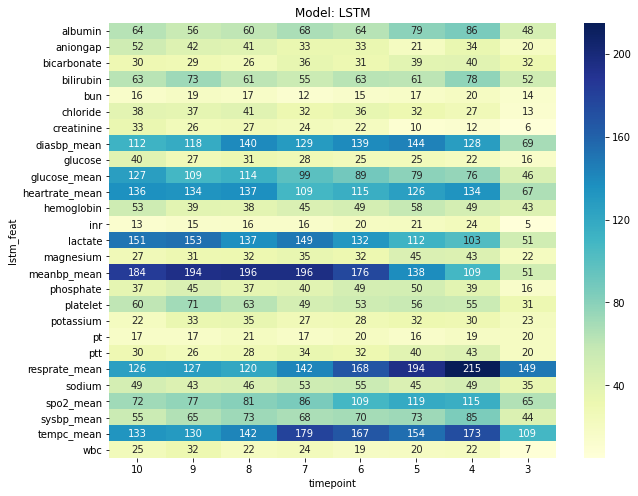

In [53]:
rank_heatmap(ranks1, model='lstm')

In [48]:
weights = {'lstm': 0.83, 'mlp': 0.82, 'rf': 0.81, 'lr': 0.71}
consensus1 = mg.magec_consensus(ranks1, use_weights=True, weights=weights, models=('mlp', 'rf', 'lr', 'lstm'))

In [49]:
consensus1.head()

,case,timepoint,winner,score,consensus,models,avg_percent_consensus,avg_percent_all
0,4,26,heartrate_mean,0.569106,1,[lr],23.997886,4.941599
1,4,25,albumin,0.517368,3,"[lstm, mlp, rf]",25.170555,17.992438
2,4,24,albumin,0.940690,3,"[lstm, mlp, rf]",31.620362,22.723027
3,4,23,albumin,0.955240,3,"[lstm, mlp, rf]",22.874001,16.064512
4,4,22,albumin,1.128312,3,"[lstm, mlp, rf]",30.627045,21.898841


In [50]:
def consensus_heatmap(consensus, timepoint=10):
    f, ax = plt.subplots(figsize=(10, 8))
    data = consensus[consensus['timepoint'] <= timepoint]
    heat = data[['case','timepoint','winner']].\
               groupby(['timepoint','winner'])['case'].\
               count().reset_index(name="count")
    heat = heat.pivot(index='winner', columns='timepoint', values='count')
    ax = sns.heatmap(heat.fillna(0), cmap="YlGnBu", annot=True, fmt='.0f',)
    ax.set_title('Consensus')
    ax.invert_xaxis()
    return

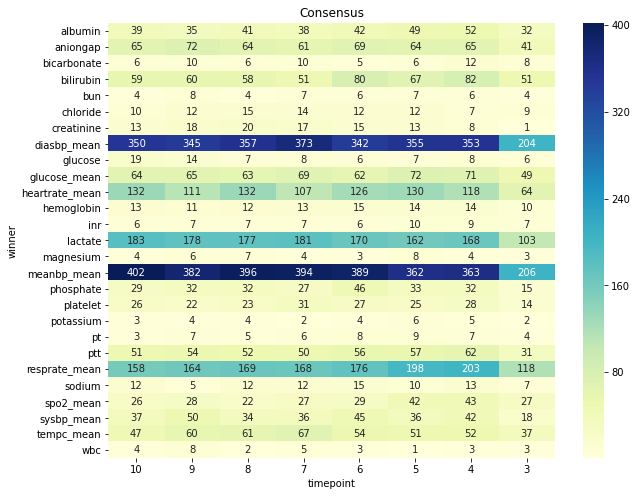

In [51]:
consensus_heatmap(consensus1)

In [52]:
consensus1[['timepoint', 'consensus']].groupby('timepoint')['consensus'].agg('mean')

timepoint
3     2.081006
4     2.070492
5     2.101883
6     2.101601
7     2.103641
8     2.121212
9     2.091063
10    2.109915
11    2.120461
12    2.119318
13    2.084540
14    2.093356
15    2.093750
16    2.078206
17    2.100352
18    2.089862
19    2.072051
20    2.075898
21    2.094619
22    2.067817
23    2.071820
24    2.038937
25    2.051974
26    2.028916
27    1.995640
Name: consensus, dtype: float64

In [68]:
pred1 = (joined.label == 1)
pred2a = (joined.orig_prob_rf < 0.5)
pred2b = (joined.orig_prob_rf >= 0.5)
pred3a = (joined.orig_prob_mlp < 0.5)
pred3b = (joined.orig_prob_mlp >= 0.5)
pred4a = (joined.orig_prob_lr < 0.5)
pred4b = (joined.orig_prob_lr >= 0.5)
pred5a = (joined.orig_prob_lstm < 0.5)
pred5b = (joined.orig_prob_lstm >= 0.5)

In [69]:
joined.case.nunique()

2083

In [79]:
# EVERYONE missed it
joined[pred1 & pred2a & pred3a & pred4a & pred5a].case.nunique()

157

In [80]:
# ONLY RF gets it right
joined[pred1 & pred2b & pred3a & pred4a & pred5a].case.nunique()

2

In [81]:
# ONLY MLP gets it right
joined[pred1 & pred2a & pred3b & pred4a & pred5a].case.nunique()

6

In [82]:
# ONLY LR gets it right
joined[pred1 & pred2a & pred3a & pred4b & pred5a].case.nunique()

175

In [83]:
# ONLY LSTM gets it right
joined[pred1 & pred2a & pred3a & pred4a & pred5b].case.nunique()

149